In [14]:
import scanpy as sc
import numpy as np
import torch
import pickle
from scBTF import SingleCellTensor, SingleCellBTF, FactorizationSet

In [7]:
adata = sc.read("data/combined_dataset_final_v2.h5ad")

In [8]:
n = 2000
sampled = adata.obs.sample(frac=1).groupby("cell_types_level_3").head(n)
adata = adata[sampled.index,:]
adata

View of AnnData object with n_obs × n_vars = 29573 × 29786
    obs: 'nCount_uncorrected', 'nFeature_uncorrected', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_cellbender_corrected', 'nFeature_cellbender_corrected', 'gem_lane', 'donor', 'year_of_dx', 'institution', 'condition', 'tissue_site', 'histo_subtype', 'age', 'sex', 'experimental_batch', 'seq_tech', 'sequencing_batch', 'replicates', 'percent.mt', 'percent.ribo', 'ident', 'scDblFinder.sample', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.ratio', 'scDblFinder.weighted', 'scDblFinder.nearestClass', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'cellbender_corrected_snn_res.0.5', 'seurat_clusters', 'cellbender_corrected_snn_res.0.3', 'SingleR.labels.hpca', 'SingleR.labels.encode', 'SingleR.labels.dice.main', 'SingleR.labels.dice.fine', 'SingleR.labels.monaco.main', 'SingleR.labels.monaco.fine', 'SingleR.labels.

In [9]:
sample_label = "donor"
celltype_label = "cell_types_level_3"

sc_tensor = SingleCellTensor.from_anndata(adata,
    sample_label=sample_label,
    celltype_label=celltype_label,
    enrich_db_genes_only=True,
    normalize=True
)
sc_tensor.tensor = sc_tensor.tensor.round()

Building tensor from matrix: 100%|██████████| 15/15 [00:00<00:00, 32.68it/s]


Decomposing tensor of shape torch.Size([15, 6, 12961]) into rank 20 matrices


100%|██████████| 20/20 [51:39<00:00, 154.97s/it]


Saved SingleCellTensor object to path results/gp_subset.pkl


In [ ]:
factorization_set = SingleCellBTF.factorize(
    sc_tensor = sc_tensor,
    rank = [20],
    model = 'gamma_poisson',
    n_restarts = 20,
    num_steps = 1500,
    init_alpha = 1e2,
    plot_var_explained = False
)

factorization_set.save(f"results/gp_subset.pkl")

In [2]:
factorization_set = FactorizationSet.load("results/gp_subset.pkl")

In [15]:
reconstructed_all = {}
for selected_rank in [20]:
    # Use median of clustered gene factors to reconstruct a final factorization
    medians = factorization_set.reconstruct_factors_from_median_gene_factor(rank = selected_rank)
    reconstructed = SingleCellBTF.factorize(
        sc_tensor = factorization_set.sc_tensor,
        rank = selected_rank,
        n_restarts = 1,
        init_alpha = 10.,
        num_steps = 1000,
        model = 'gamma_poisson_fixed',
        fixed_mode = 2,
        fixed_value = torch.from_numpy(medians.T).float(),
        plot_var_explained = False
    )

    gene_factor = reconstructed.get_factorization(rank = selected_rank, restart_index = 0).gene_factor['mean'].numpy()
    print((1 - np.isclose(medians.T, gene_factor, atol=2)).sum(), '/', medians.flatten().shape[0], ' mismatches in final gene factors')
    print(f'variance explained by reconstructed factorization = {reconstructed.variance_explained(rank=selected_rank, restart_index=0).item() :.3}')
    reconstructed_all[selected_rank] = reconstructed

with open('results/rec_lr_chl_gpBTF.pkl', 'wb') as file:
    pickle.dump(reconstructed_all, file)

Decomposing tensor of shape torch.Size([15, 6, 12961]) into rank 20 matrices


100%|██████████| 1/1 [01:35<00:00, 95.98s/it]

415 / 259220  mismatches in final gene factors
variance explained by reconstructed factorization = 0.866


In [16]:
with open('results/rec_lr_chl_gpBTF.pkl', 'rb') as file:
    reconstructed_all = pickle.load(file)

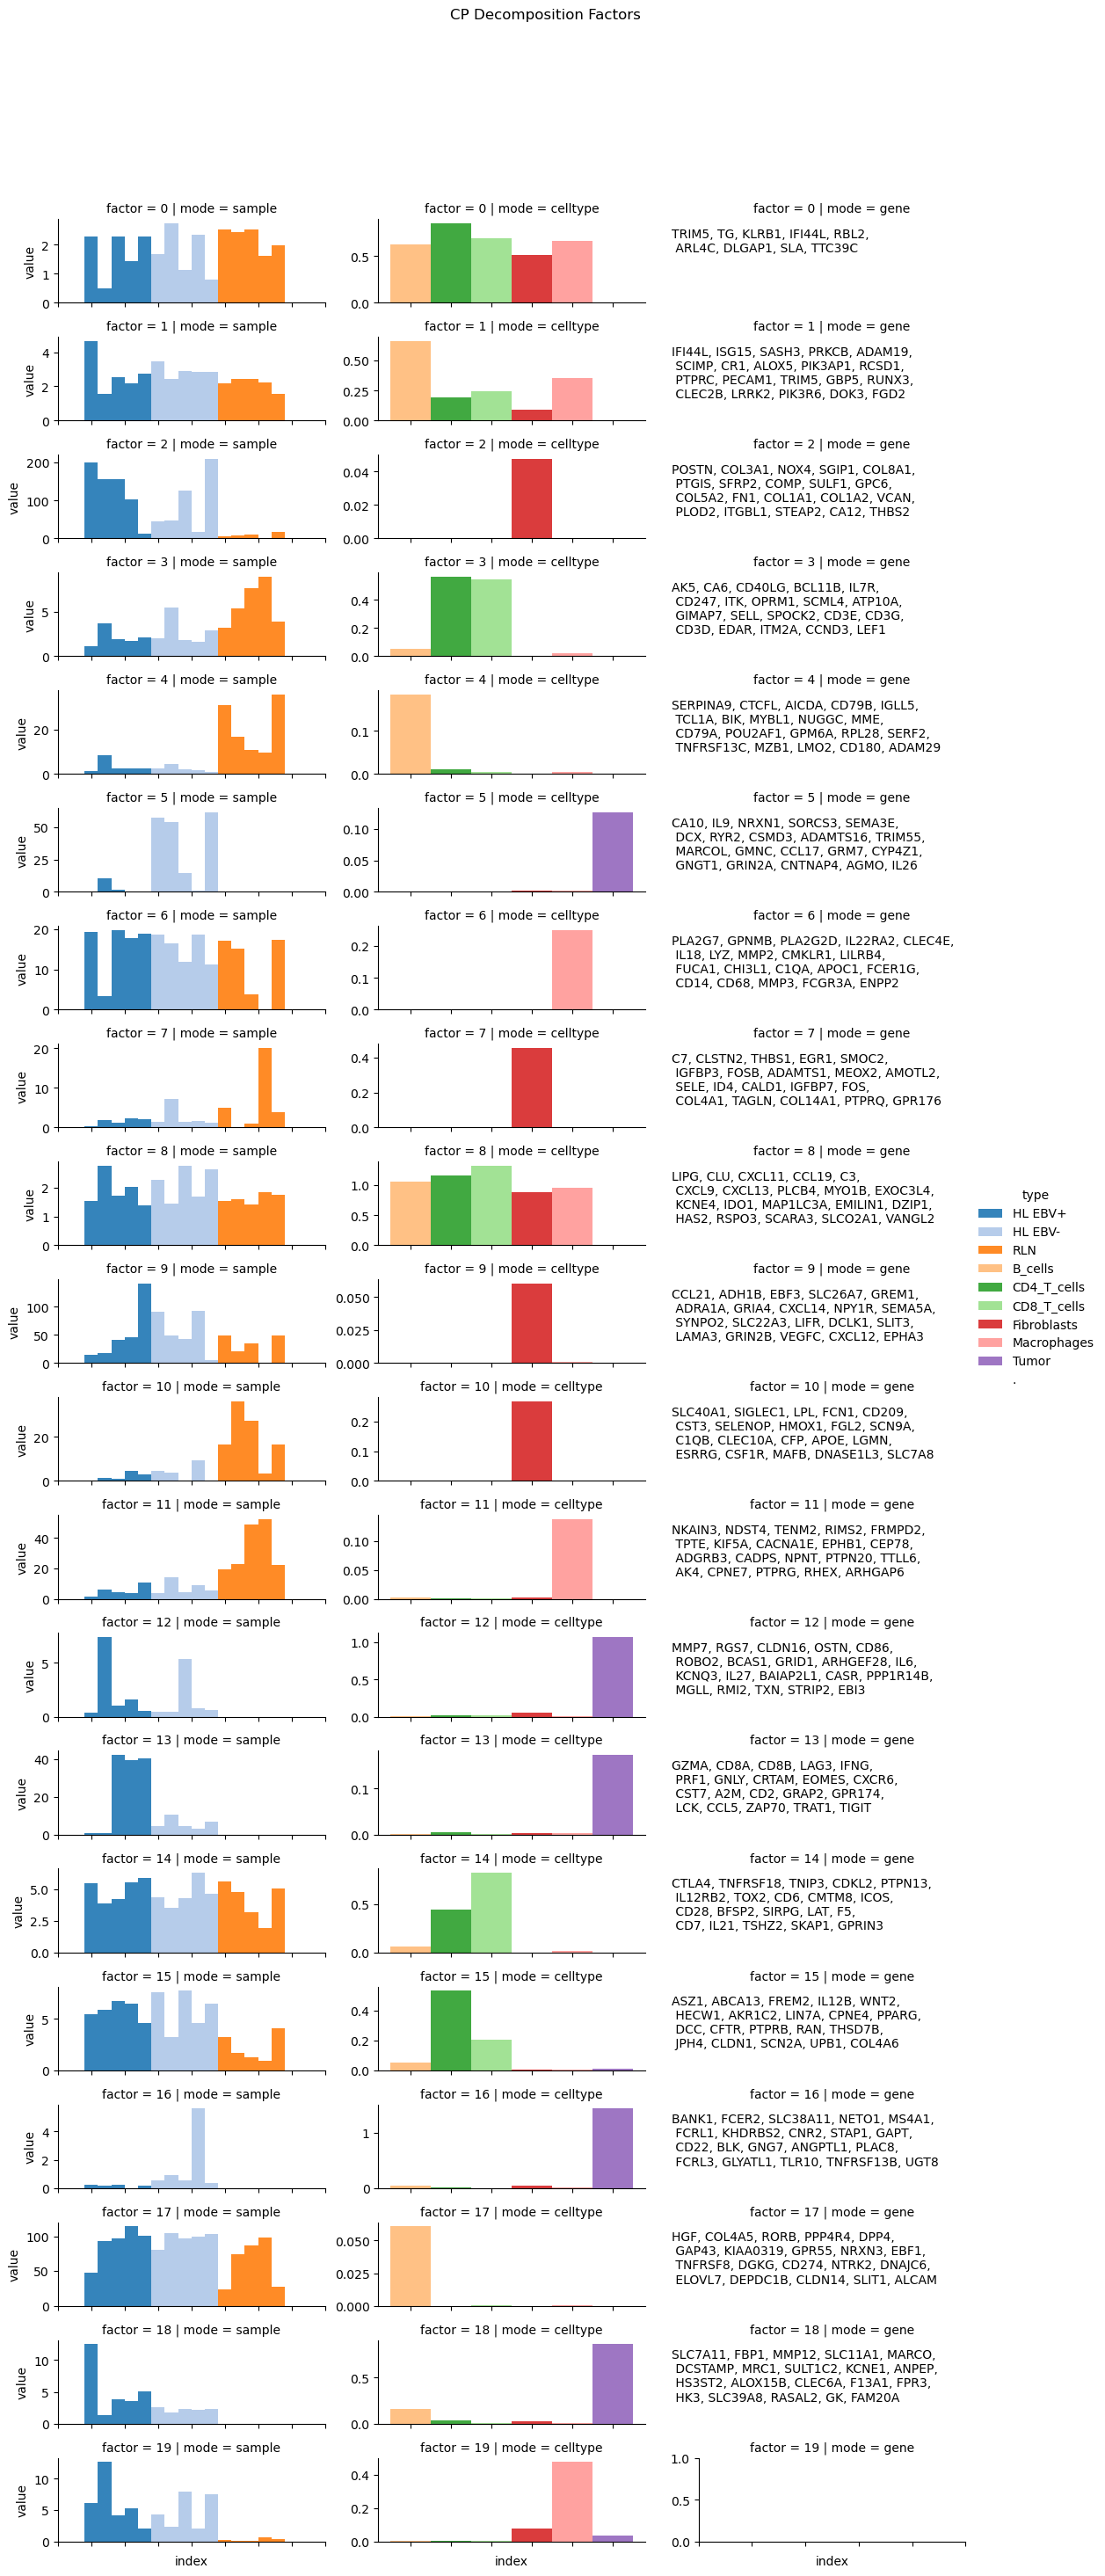

In [17]:
selected_rank = 20
reconstructed = reconstructed_all[selected_rank]
reconstructed.sc_tensor.region_list = reconstructed.sc_tensor.celltype_list
reconstructed.sc_tensor.sample_features.loc['H09_370','ebv_status'] = 'positive'
reconstructed.sc_tensor.sample_features['sample_type'] = \
    reconstructed.sc_tensor.sample_features['condition'].astype(str) + \
    reconstructed.sc_tensor.sample_features['ebv_status'].astype(str).apply(lambda x:''if x=='na' else '_'+x)
reconstructed.sc_tensor.sample_features['sample_type'] = \
    reconstructed.sc_tensor.sample_features['sample_type'].map({'HL_negative': 'HL EBV-', 'HL_positive': 'HL EBV+', 'RLN': 'RLN'})

fig = reconstructed.plot_components(rank=selected_rank, restart_index=0, entropy = 2, eps = 0.5,
                                    threshold = 0.3, sort_by = 'other', plot_erichment_terms=False,
                                    normalize_gene_factors=True)
fig